# Fit model on hundreds of antibodies

Using a penalisation. Obsolete

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
import torch
from math import ceil
sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [2]:

# --- Load ---
df = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df=df[df['i']>=349] 
df=df[df['i']<=526]



In [3]:
df

,Unnamed: 0,i,wt,mut,bloom_ace2_binding,bloom_expression,chan_expression,chan_ace2_binding,fitness_eve,dissimilarity_charge_hydro,accessibility_wcn,evescape,max_escape_experiment_bloom,is_escape_experiment_bloom,max_escape_experiment_xie,is_escape_experiment_xie,is_escape_experiment_all,mutation,counts,first_seen
135,135,349,S,A,-0.34,-1.13,-3.83,-2.68,-6.902246,-1.222299,-1.417140,-2.387840,0.00000,False,0.000000,False,False,S349A,30.0,2021-01
136,136,349,S,C,-0.12,-2.03,-1.77,-0.78,-7.368066,-1.609191,-1.417140,-2.563646,0.00000,False,0.000000,False,False,S349C,1.0,2022-05
137,137,349,S,F,-2.03,-2.50,-3.46,-2.75,-7.207227,-0.559057,-1.417140,-2.345080,0.00000,False,0.000000,False,False,S349F,11.0,2020-05
138,138,349,S,G,-0.59,-2.08,-1.04,-0.77,-6.908368,-1.388110,-1.417140,-2.418569,0.00000,False,0.000000,False,False,S349G,1.0,2022-04
139,139,349,S,I,-4.25,-2.69,-3.35,-1.95,-6.500989,-0.337976,-1.417140,-2.156518,0.00000,False,0.000000,False,False,S349I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1531,526,G,E,-0.01,-0.13,NaN,NaN,-8.738202,1.067187,-1.885148,-3.535322,0.07851,False,0.010790,False,False,G526E,2.0,2020-10
1532,1532,526,G,R,-0.08,-0.30,NaN,NaN,-8.578857,3.241148,-1.885148,-3.269983,0.04760,False,0.008869,False,False,G526R,3.0,2021-10
1533,1533,526,G,S,-0.02,-0.14,NaN,NaN,-8.599188,-1.388110,-1.885148,-3.868234,0.05173,False,0.008869,False,False,G526S,NaN,NaN
1534,1534,526,G,V,-0.04,-0.12,NaN,NaN,-8.664563,-1.461803,-1.885148,-3.899844,0.05142,False,0.008869,False,False,G526V,1.0,2022-01


In [4]:
Y_ALL = (df["counts"] >= 100).to_numpy().astype(int)
scores_baseline=df['evescape'].to_numpy()
#average of y
print(Y_ALL.sum()/len(Y_ALL))

0.185581727337616


In [5]:
def get_sequence(WT, site,	mutation):
    #site is expected to be 349 instead of 0
    site=site-349
    return WT[:site]+mutation+WT[site+1:]

#example:

df['sequence']=df.apply(lambda x: get_sequence(WT, x['i'],  x['mut']), axis=1)
    

In [6]:
with open('single_variants.fasta', 'w') as f:
    for index, row in df.iterrows():
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')
seqs=Proteins_utils.load_FASTA('single_variants.fasta', drop_duplicates=False)

# EscapeMap scoring

In [8]:
from escape_map_torch import EscapeMapTorch
raw_conc = np.full(len(KD_VECTORS), -8.0, dtype=np.float64)  # antibodies
model = EscapeMapTorch(
    rbm=RBM,
    kd_vectors=KD_VECTORS,
    ace2_vector=ACE2_KD_VECTOR,
    raw_concentrations=raw_conc,
    raw_ace2=-9,      # ACE2 concentration in log10 space
    raw_beta=-1,
)
scores=-model(seqs)
print('scores shape:', scores)
#auc to compare score and y

auc = roc_auc_score(Y_ALL, scores.detach().numpy())
print("AUC:", auc)
#params are the individual concentrations for each Ab (dont put -12 everywhere), raw_ace2, raw_beta
# i want to find best parameters to maximize predictive power=auc, but could be something else


scores shape: tensor([578.0441, 574.5410, 574.5409,  ..., 576.8531, 576.6968, 572.7727],
       dtype=torch.float64, grad_fn=<NegBackward0>)
AUC: 0.6582569271219577


In [9]:


# ===== Training with BCE on sigmoid(score - WT) =====
def fit_escape_map_sigmoid_diff(
    seqs, y, rbm, kd_vectors, ace2_vector,
    epochs=50, batch_size=512, lr=2e-1, weight_decay=1e-5,
    device=None, dtype=torch.float64
):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    X = torch.as_tensor(seqs, dtype=torch.long, device=device)
    Y = torch.as_tensor(y.astype(float), dtype=dtype, device=device)

    model = EscapeMapTorch(
        rbm=rbm, kd_vectors=kd_vectors, ace2_vector=ace2_vector,
        total_beta=1.0, device=device, dtype=dtype
    ).to(device)

    # Optimizer: now include raw_concentrations
    params = [model.raw_concentrations, model.raw_beta, model.raw_ace2, model.raw_total_beta]
    opt = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

    # Class imbalance handling
    pos = float(Y.sum().item()); neg = float(Y.numel() - pos)
    pos_weight = torch.tensor(neg / max(pos, 1.0), dtype=dtype, device=device)
    bce = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    N = X.size(0); idx_all = torch.arange(N, device=device)
    WT = torch.as_tensor(WT_SEQ, dtype=torch.long, device=device)

    for _ in range(epochs):
        perm = idx_all[torch.randperm(N, device=device)]
        for bi in range(ceil(N / batch_size)):
            bidx = perm[bi * batch_size : (bi + 1) * batch_size]
            xb, yb = X[bidx], Y[bidx]

            opt.zero_grad()
            wt_score = -model(WT)               # scalar
            scores_b = -model(xb)               # [B]
            logits = scores_b - wt_score        # classification margin vs WT
            loss = bce(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=10.0)
            opt.step()
            print('model.raw_beta:', model.raw_beta.item())
            print('model.raw_ace2:', model.raw_ace2.item())

    # Final evaluation
    with torch.no_grad():
        wt_score = -model(WT)
        scores = -model(X)
        logits_full = scores - wt_score
        prob = torch.sigmoid(logits_full).cpu().numpy()
        auc = roc_auc_score(y, prob)
        rc = model.raw_concentrations.detach().cpu().numpy()
        rb = float(model.raw_beta.detach().cpu())
        ra = float(model.raw_ace2.detach().cpu())
        tb = float(torch.exp(model.raw_total_beta).detach().cpu())  # total_beta in linear scale

    return {
        "model": model,
        "prob": prob,
        "AUC": auc,
        "raw_concentrations": rc,
        "raw_beta": rb,
        "raw_ace2": ra,
        "total_beta": tb,
    }


out = fit_escape_map_sigmoid_diff(
    seqs=seqs, y=Y_ALL, rbm=RBM, kd_vectors=KD_VECTORS, ace2_vector=ACE2_KD_VECTOR,
    epochs=30, batch_size=1024, lr=2e-1, weight_decay=1e-5,
)
print(out["AUC"], out["raw_ace2"], out["raw_beta"], out["total_beta"], out["raw_concentrations"])
# --- save scores ---
scores_df = pd.DataFrame({
    "seq_index": np.arange(len(seqs)),
    "y": Y_ALL,
    "score": out["prob"]
})
scores_df.to_csv("scores_sigmoid_diff.csv", index=False)

# --- save parameters ---
ab_names = list(KD_VECTORS.keys())
param_row = {
    "AUC": out["AUC"],
    "raw_beta": out["raw_beta"],
    "raw_ace2": out["raw_ace2"],
    "total_beta": out["total_beta"],
}
for name, val in zip(ab_names, out["raw_concentrations"]):
    param_row[f"raw_c_{name}"] = float(val)

params_df = pd.DataFrame([param_row])
params_df.to_csv("params_sigmoid_diff.csv", index=False)




model.raw_beta: -2.1999999948402253
model.raw_ace2: -10.199999543319981
model.raw_beta: -2.3837293975249145
model.raw_ace2: -10.399494239362266
model.raw_beta: -2.5439809933816826
model.raw_ace2: -10.599188854293232
model.raw_beta: -2.6795527429121146
model.raw_ace2: -10.799638732230799
model.raw_beta: -2.7927111924322063
model.raw_ace2: -11.001144839473692
model.raw_beta: -2.8918944615382145
model.raw_ace2: -11.203664972477394
model.raw_beta: -2.9759329712037177
model.raw_ace2: -11.40675325024137
model.raw_beta: -3.047441087146479
model.raw_ace2: -11.61109340048929
model.raw_beta: -3.1080070378121802
model.raw_ace2: -11.81524283185689
model.raw_beta: -3.1597089725230934
model.raw_ace2: -12.020854780286438
model.raw_beta: -3.202539562924862
model.raw_ace2: -12.226241152464048
model.raw_beta: -3.2407482168252884
model.raw_ace2: -12.431806841401487
model.raw_beta: -3.272042873564704
model.raw_ace2: -12.63709301204174
model.raw_beta: -3.2996172927940277
model.raw_ace2: -12.842127114487097

In [10]:


model = load_escape_map_from_csv("params_sigmoid_diff.csv")
scores=-model(seqs)
wt_score = -model(WT_SEQ)
df['escapemap'] = scores-wt_score.item()
df

,Unnamed: 0,i,wt,mut,bloom_ace2_binding,bloom_expression,chan_expression,chan_ace2_binding,fitness_eve,dissimilarity_charge_hydro,...,max_escape_experiment_bloom,is_escape_experiment_bloom,max_escape_experiment_xie,is_escape_experiment_xie,is_escape_experiment_all,mutation,counts,first_seen,sequence,escapemap
135,135,349,S,A,-0.34,-1.13,-3.83,-2.68,-6.902246,-1.222299,...,0.00000,False,0.000000,False,False,S349A,30.0,2021-01,AVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.263098
136,136,349,S,C,-0.12,-2.03,-1.77,-0.78,-7.368066,-1.609191,...,0.00000,False,0.000000,False,False,S349C,1.0,2022-05,CVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.595026
137,137,349,S,F,-2.03,-2.50,-3.46,-2.75,-7.207227,-0.559057,...,0.00000,False,0.000000,False,False,S349F,11.0,2020-05,FVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.595033
138,138,349,S,G,-0.59,-2.08,-1.04,-0.77,-6.908368,-1.388110,...,0.00000,False,0.000000,False,False,S349G,1.0,2022-04,GVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.259146
139,139,349,S,I,-4.25,-2.69,-3.35,-1.95,-6.500989,-0.337976,...,0.00000,False,0.000000,False,False,S349I,NaN,NaN,IVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-4.212406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1531,526,G,E,-0.01,-0.13,NaN,NaN,-8.738202,1.067187,...,0.07851,False,0.010790,False,False,G526E,2.0,2020-10,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.748654
1532,1532,526,G,R,-0.08,-0.30,NaN,NaN,-8.578857,3.241148,...,0.04760,False,0.008869,False,False,G526R,3.0,2021-10,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.295240
1533,1533,526,G,S,-0.02,-0.14,NaN,NaN,-8.599188,-1.388110,...,0.05173,False,0.008869,False,False,G526S,NaN,NaN,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.668584
1534,1534,526,G,V,-0.04,-0.12,NaN,NaN,-8.664563,-1.461803,...,0.05142,False,0.008869,False,False,G526V,1.0,2022-01,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,-0.274246


In [11]:


#group per site i and save mean escapemap score
df_site=df.groupby('i').agg({'escapemap':'mean', 'evescape':'mean', 'first_seen':'first'}).reset_index()
df_site.to_csv('site_scores.csv', index=False)
#print top 10 sites
df_site.sort_values(by='escapemap', ascending=False).head(10)


,i,escapemap,evescape,first_seen
135,484,5.276051,-0.979746,2020-01
137,486,3.781180,-1.415157,2021-06
141,490,2.203545,-1.275252,2021-03
138,487,1.664625,-1.761427,2021-03
107,456,0.826006,-1.441302,2020-11
144,493,0.608669,-0.993658,2020-01
136,485,0.491651,-1.282629,2021-01
29,378,0.348322,-2.102936,2020-09
68,417,0.142857,-1.142328,2020-01
123,472,0.123343,-1.252417,2020-01


# Train 80% subset

In [18]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from math import ceil
from sklearn.metrics import roc_auc_score
MERGED_KD_VECTORS=KD_VECTORS | BA1_KD_VECTORS

# --- stratified subset indices (unused here, kept for reference) ---
def stratified_subset_indices(y, frac, seed=0):
    y = np.asarray(y).astype(int)
    rng = np.random.default_rng(seed)
    pos = rng.choice(np.flatnonzero(y == 1), size=max(1, int(np.ceil(frac * (y == 1).sum()))), replace=False)
    neg = rng.choice(np.flatnonzero(y == 0), size=max(1, int(np.ceil(frac * (y == 0).sum()))), replace=False)
    idx = np.concatenate([pos, neg]); rng.shuffle(idx); return idx

# --- unchanged model class: EscapeMapTorch ---
# assumed available in scope along with: RBM, MERGED_KD_VECTORS, ACE2_KD_VECTOR, WT_SEQ, seqs, Y_ALL

def fit_escape_map_sigmoid_diff_train_test(
    seqs, y, rbm, kd_vectors, ace2_vector,
    epochs=50, batch_size=512, lr=2e-1, weight_decay=1e-5, alpha=None,
    device=None, dtype=torch.float64, train_idx=None, seed=0
):
    torch.manual_seed(seed); np.random.seed(seed)
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    X = torch.as_tensor(seqs, dtype=torch.long, device=device)
    Y = torch.as_tensor(np.asarray(y).astype(float), dtype=dtype, device=device)

    # subset for training
    if train_idx is None:
        Xtr, Ytr = X, Y
    else:
        ti = torch.as_tensor(train_idx, dtype=torch.long, device=device)
        Xtr, Ytr = X[ti], Y[ti]

    model = EscapeMapTorch(rbm, kd_vectors, ace2_vector, total_beta=1.0, device=device, dtype=dtype).to(device)
    params = [model.raw_concentrations, model.raw_beta, model.raw_ace2, model.raw_total_beta]
    opt = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

    # class weight from the subset
    pos = float(Ytr.sum().item()); neg = float(Ytr.numel() - pos)
    pos_weight = torch.tensor(neg / max(pos, 1.0), dtype=dtype, device=device)
    bce = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    WT = torch.as_tensor(WT_SEQ, dtype=torch.long, device=device)
    Ntr = Xtr.size(0); idx_local = torch.arange(Ntr, device=device)

    for _ in range(epochs):
        perm = idx_local[torch.randperm(Ntr, device=device)]
        for bi in range(ceil(Ntr / batch_size)):
            bidx = perm[bi * batch_size : (bi + 1) * batch_size]
            xb, yb = Xtr[bidx], Ytr[bidx]
            opt.zero_grad()
            logits = (-model(xb)) - (-model(WT))   # margin vs WT
            loss = bce(logits, yb)

            # one-sided penalty: penalize only positive concentrations, pushes toward ≤ 0
            if alpha is not None and alpha > 0:
                conc_pen = alpha * model.raw_concentrations.sum()
                loss = loss + conc_pen

            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, 10.0)
            opt.step()

    with torch.no_grad():
        logits_full = (-model(X)) - (-model(WT))
        prob = torch.sigmoid(logits_full).cpu().numpy()

    return {
        "model": model,
        "prob": prob,
        "raw_concentrations": model.raw_concentrations.detach().cpu().numpy(),
        "raw_beta": float(model.raw_beta.detach().cpu()),
        "raw_ace2": float(model.raw_ace2.detach().cpu()),
        "total_beta": float(torch.exp(model.raw_total_beta).detach().cpu()),
    }

# ===== Single split (seed=0) and alpha sweep in log scale =====
os.makedirs("training_80_multi_ab", exist_ok=True)

N = len(Y_ALL)
indices = np.arange(N)
rng = np.random.RandomState(0)
rng.shuffle(indices)

# 80/20 split
split_point = int(0.8 * N)
train_idx = indices[:split_point].tolist()
test_idx  = indices[split_point:].tolist()

# Define alphas: include baseline 0 then log-spaced >0
alphas=np.linspace(0.0001, 0.001, 10)
print(alphas)

seed_dir = os.path.join("training_80_multi_ab", "seed_0")
os.makedirs(seed_dir, exist_ok=True)

# collect all params across alphas
all_params_rows = []

for alpha in alphas:
    out = fit_escape_map_sigmoid_diff_train_test(
        seqs=seqs,
        y=Y_ALL,
        rbm=RBM,
        kd_vectors=MERGED_KD_VECTORS,
        ace2_vector=ACE2_KD_VECTOR,
        epochs=30,
        batch_size=1024,
        lr=2e-1,
        weight_decay=1e-5,
        alpha=float(alpha),
        train_idx=train_idx,
        seed=0,
    )

    # test AUC
    y_true_test = np.asarray(Y_ALL, dtype=int)[test_idx]
    y_score_test = out["prob"][test_idx]
    auc_test = roc_auc_score(y_true_test, y_score_test)

    # save scores
    test_mask = np.zeros(N, dtype=int)
    test_mask[test_idx] = 1
    scores_df = pd.DataFrame({
        "seq_index": np.arange(N),
        "y": Y_ALL,
        "score": out["prob"],
        "test": test_mask,
    })

    alpha_dir = os.path.join(seed_dir, f"alpha_{alpha:g}")
    os.makedirs(alpha_dir, exist_ok=True)
    scores_df.to_csv(os.path.join(alpha_dir, "scores.csv"), index=False)

    # save parameters
    ab_names = list(MERGED_KD_VECTORS.keys())
    param_row = {
        "alpha": float(alpha),
        "AUC_test": float(auc_test),
        "raw_beta": out["raw_beta"],
        "raw_ace2": out["raw_ace2"],
        "total_beta": out["total_beta"],
    }
    for name, val in zip(ab_names, out["raw_concentrations"]):
        param_row[f"raw_c_{name}"] = float(val)
    params_df = pd.DataFrame([param_row])
    params_df.to_csv(os.path.join(alpha_dir, "params.csv"), index=False)

    all_params_rows.append(param_row)
    print(f"alpha={alpha:g}  AUC_test={auc_test:.3f}  saved in {alpha_dir}")

# Save combined parameters across alphas
all_params_df = pd.DataFrame(all_params_rows)
all_params_df.to_csv(os.path.join(seed_dir, "params_all.csv"), index=False)
print(f"Saved combined params to {os.path.join(seed_dir, 'params_all.csv')}")


[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001 ]
alpha=0.0001  AUC_test=0.748  saved in training_80_multi_ab\seed_0\alpha_0.0001
alpha=0.0002  AUC_test=0.758  saved in training_80_multi_ab\seed_0\alpha_0.0002
alpha=0.0003  AUC_test=0.750  saved in training_80_multi_ab\seed_0\alpha_0.0003
alpha=0.0004  AUC_test=0.754  saved in training_80_multi_ab\seed_0\alpha_0.0004
alpha=0.0005  AUC_test=0.749  saved in training_80_multi_ab\seed_0\alpha_0.0005
alpha=0.0006  AUC_test=0.747  saved in training_80_multi_ab\seed_0\alpha_0.0006
alpha=0.0007  AUC_test=0.745  saved in training_80_multi_ab\seed_0\alpha_0.0007
alpha=0.0008  AUC_test=0.743  saved in training_80_multi_ab\seed_0\alpha_0.0008
alpha=0.0009  AUC_test=0.746  saved in training_80_multi_ab\seed_0\alpha_0.0009
alpha=0.001  AUC_test=0.743  saved in training_80_multi_ab\seed_0\alpha_0.001
Saved combined params to training_80_multi_ab\seed_0\params_all.csv


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\maria\AppData\Local\Temp\ipykernel_26380\3372703130.py:3: SyntaxWarning: invalid escape sequence '\s'
  df=pd.read_csv('training_80_multi_ab\seed_0\params_all.csv')


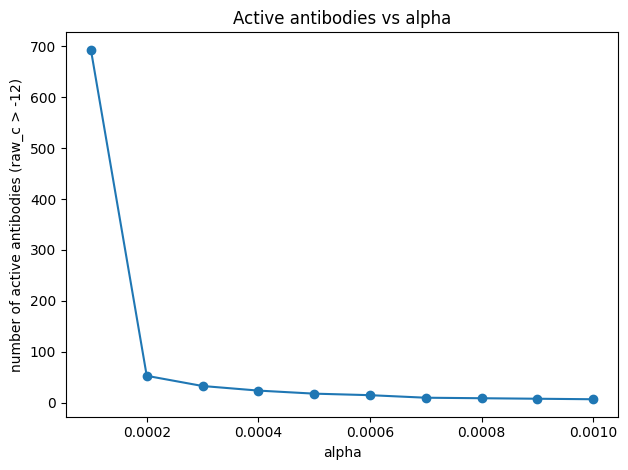

In [19]:
import matplotlib.pyplot as plt
# all_params_df.to_csv(os.path.join(seed_dir, "params_all.csv"), index=False)
df=pd.read_csv('training_80_multi_ab\seed_0\params_all.csv')
# Use the aggregated table created above
# df = all_params_df.copy()

# Columns holding raw concentrations
raw_cols = [c for c in df.columns if c.startswith("raw_c_")]

# Count actives per alpha: raw_c > -12
df["active_count"] = (df[raw_cols] > -12).sum(axis=1)

# Sort by alpha
df = df.sort_values("alpha")

# Plot
plt.figure()
plt.plot(df["alpha"].values, df["active_count"].values, marker="o")
plt.xlabel("alpha")
plt.ylabel("number of active antibodies (raw_c > -12)")
plt.title("Active antibodies vs alpha")
plt.tight_layout()
plt.show()

# Optional: save data
df[["alpha", "active_count"]].to_csv(os.path.join(seed_dir, "active_counts_vs_alpha.csv"), index=False)


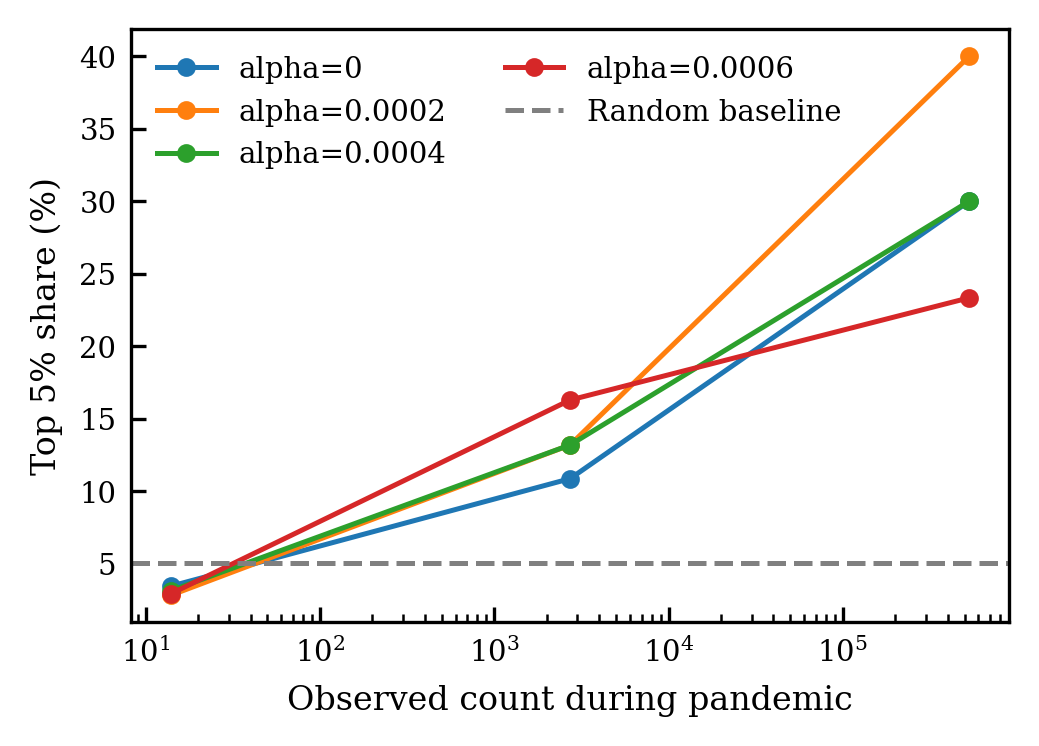

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ----------------- Params -----------------
NB_EDGES = 4           # number of log-space edges => NB_EDGES-1 bins
th = 95                # percentile threshold (top 5%)
seed_dir = "training_80_multi_ab/seed_0"  # where alpha_*/scores.csv live

# ----------------- Load & restrict to RBD -----------------
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()

# Use all rows as observation universe
obs = df_base.copy()

# ----------------- Build log-spaced frequency bins -----------------
freq = pd.to_numeric(obs["count"], errors="coerce").fillna(0).astype(float)
freq_clip = np.clip(freq.values, 1.0, None)

lo, hi = float(freq_clip.min()), float(freq_clip.max())
if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
    raise ValueError("Frequency range invalid; cannot create log bins.")

edges_log = np.linspace(np.log10(lo), np.log10(hi), NB_EDGES)
edges = 10.0 ** edges_log
midpoints = np.sqrt(edges[:-1] * edges[1:])  # geometric mean per bin

# Precompute bin masks over obs
bin_masks = []
for i in range(NB_EDGES - 1):
    left, right = edges[i], edges[i+1]
    if i < NB_EDGES - 2:
        bin_mask = (freq_clip >= left) & (freq_clip < right)
    else:
        bin_mask = (freq_clip >= left) & (freq_clip <= right)
    bin_masks.append(bin_mask)

# ----------------- Helper -----------------
def share_top_percent(values, threshold, base_mask):
    n = int(base_mask.sum())
    if n == 0:
        return np.nan
    return 100.0 * np.sum(values[base_mask] >= threshold) / n

# ----------------- Collect curves for each alpha -----------------
alpha_curves = {}
alpha_vals = []

for d in sorted(os.listdir(seed_dir)):
    if not d.startswith("alpha_"):
        continue
    try:
        alpha = float(d.split("_", 1)[1])
    except Exception:
        continue
    if alpha not in [0, 0.0002, 0.0004, 0.0006]:
        continue

    scores_path = os.path.join(seed_dir, d, "scores.csv")
    if not os.path.isfile(scores_path):
        continue

    df_sc = pd.read_csv(scores_path)
    # Expect same length and alignment as df_base
    if len(df_sc) != len(obs):
        # fallback: try align by seq_index if available on both
        if "seq_index" in df_sc.columns and "seq_index" in obs.columns:
            df_sc = df_sc.set_index("seq_index").loc[obs["seq_index"]].reset_index()
        else:
            raise ValueError(f"Length mismatch for {scores_path}")

    vals = pd.to_numeric(df_sc["score"], errors="coerce").to_numpy()
    test_mask = (df_sc["test"].to_numpy().astype(int) == 1)

    # Threshold computed on TEST only for this alpha
    if test_mask.sum() == 0:
        continue
    thr_alpha = np.nanpercentile(vals[test_mask], th)

    curve = []
    for bm in bin_masks:
        mask = bm & test_mask
        curve.append(share_top_percent(vals, thr_alpha, mask))

    alpha_curves[alpha] = np.array(curve, dtype=float)
    alpha_vals.append(alpha)

# ----------------- Plot -----------------
random_baseline = 100 - th

mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))
x = midpoints

for alpha in sorted(alpha_vals):
    ax.plot(x, alpha_curves[alpha], marker="o", label=f"alpha={alpha:g}")

ax.axhline(random_baseline, linestyle="--", label="Random baseline", color="grey")

ax.set_xscale("log")
ax.set_xlabel("Observed count during pandemic")
ax.set_ylabel(f"Top {100-th}% share (%)")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best", ncol=2)

fig.tight_layout(pad=0.5)
plt.show()


1401
1401
1401
1401
1401
1401
1401
1401
1401
1401
1401


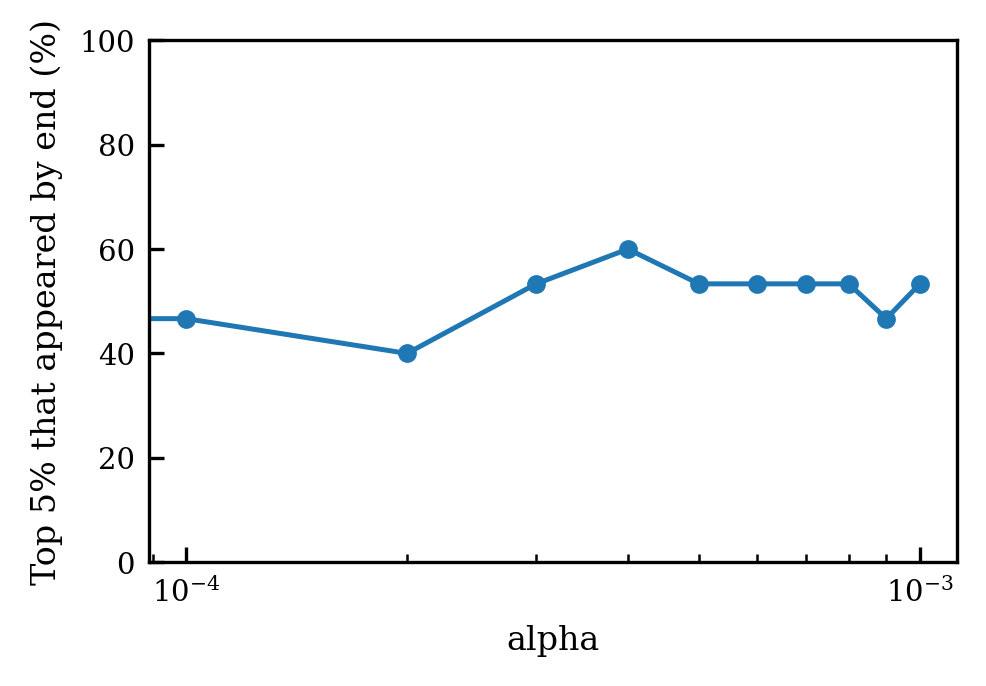

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Inputs ---
seed_dir = "training_80_multi_ab/seed_0"   # contains alpha_*/scores.csv
base_csv = "rbd_dist_one_scores_gisaid.csv"

# --- Load base and "appeared by end" mask ---
df_base = pd.read_csv(base_csv)

# If you want to restrict to RBD indices, uncomment:
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()

# Pick counts column and define "appeared" = reached 100 at some point (cumulative, end of dataset)
if "counts_100" in df_base.columns:
    counts = pd.to_numeric(df_base["counts_100"], errors="coerce").fillna(0).to_numpy()
elif "count_100" in df_base.columns:
    counts = pd.to_numeric(df_base["count_100"], errors="coerce").fillna(0).to_numpy()
elif "count" in df_base.columns:
    counts = pd.to_numeric(df_base["count"], errors="coerce").fillna(0).to_numpy()
else:
    raise ValueError("No counts column found (expected one of: counts_100, count_100, count).")

appeared = counts > 100  # cumulative-at-end criterion

# --- Collect per-alpha: among test-set top 5% scores, fraction that appeared ---
alpha_vals = []
pct_top5_appeared = []

for d in sorted(os.listdir(seed_dir)):
    if not d.startswith("alpha_"):
        continue
    try:
        alpha = float(d.split("_", 1)[1])
    except Exception:
        continue

    scores_path = os.path.join(seed_dir, d, "scores.csv")
    if not os.path.isfile(scores_path):
        continue

    sc = pd.read_csv(scores_path)
    print(len(df_base))

    # Align rows to base by seq_index if needed
    if len(sc) != len(df_base):
        if "seq_index" in sc.columns and "seq_index" in df_base.columns:
            sc = sc.set_index("seq_index").loc[df_base["seq_index"]].reset_index()
        else:
            raise ValueError(f"Length mismatch for {scores_path}")

    scores = pd.to_numeric(sc["score"], errors="coerce").to_numpy()
    test_mask = sc["test"].to_numpy().astype(int) == 1

    n_test = int(test_mask.sum())
    if n_test == 0:
        continue

    # Threshold on TEST only for this alpha: top 5%
    thr = np.nanpercentile(scores[test_mask], 95)
    top_mask = (scores >= thr) & test_mask

    n_top = int(top_mask.sum())
    if n_top == 0:
        pct = np.nan
    else:
        pct = 100.0 * appeared[top_mask].sum() / n_top

    alpha_vals.append(alpha)
    pct_top5_appeared.append(pct)

# --- Assemble, save, and plot ---
out_df = pd.DataFrame({"alpha": alpha_vals, "pct_top5_appeared": pct_top5_appeared})
out_df = out_df.sort_values("alpha").reset_index(drop=True)
out_df.to_csv(os.path.join(seed_dir, "top5_appeared_cumulative_vs_alpha.csv"), index=False)

mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.2, 2.2))
ax.plot(out_df["alpha"], out_df["pct_top5_appeared"], marker="o")
ax.set_xscale("log")
ax.set_xlabel("alpha")
ax.set_ylabel("Top 5% that appeared by end (%)")
ax.set_ylim(0, 100)
ax.tick_params(direction="in", which="both", top=False, right=False)
fig.tight_layout(pad=0.5)
plt.show()


Set size = 1401


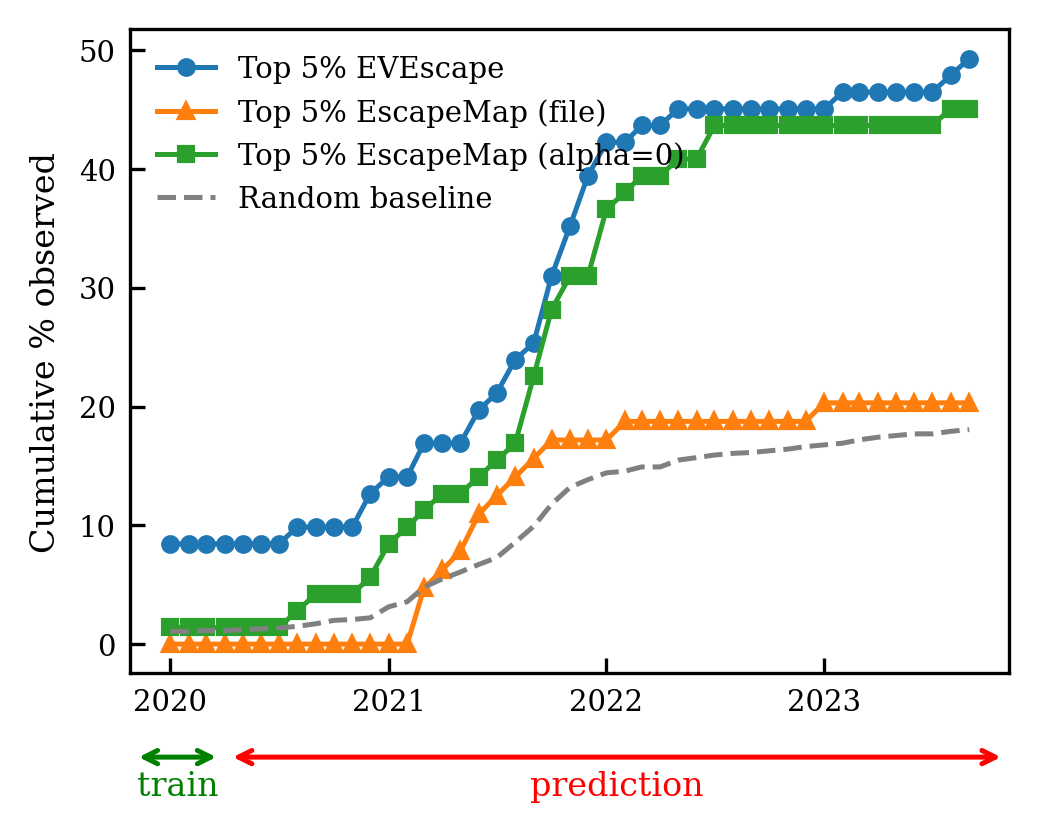

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import os

# --- Load base ---
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")
df_base.loc[df_base['count'] < 100, 'first_seen_100'] = pd.NaT  # mask low-count dates

th = 95  # top 5%

# ---------- Prepare frame ----------
df = df_base.copy()

# EscapeMap scores (baseline file)
df_em = pd.read_csv("results_periods_smaller_training/scores_sigmoid_diff_allab_2020-04.csv")
col_em = "score" if "score" in df_em.columns else "scores"
if len(df_em) != len(df):
    if "seq_index" in df_em.columns and "seq_index" in df.columns:
        df = df.set_index("seq_index").loc[df_em["seq_index"]].reset_index()
    else:
        raise RuntimeError("scores file not aligned with base.")
df["escapemap"] = pd.to_numeric(df_em[col_em], errors="coerce")

# Alpha=0 scores
alpha0_path = "training_80_multi_ab/seed_0/alpha_0/scores.csv"
if not os.path.isfile(alpha0_path):
    raise FileNotFoundError(alpha0_path)
df_a0 = pd.read_csv(alpha0_path)
if len(df_a0) != len(df):
    if "seq_index" in df_a0.columns and "seq_index" in df.columns:
        df_a0 = df_a0.set_index("seq_index").loc[df["seq_index"]].reset_index()
    else:
        raise RuntimeError("alpha=0 scores not aligned with base.")
scores_a0 = pd.to_numeric(df_a0["score"], errors="coerce").to_numpy()

print(f"Set size = {len(df)}")

# thresholds
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)
thr_a0  = np.nanpercentile(scores_a0, th)

# subsets (top 5%)
top_eve = df[df["evescape"]  >= thr_eve].copy()
top_em  = df[df["escapemap"] >= thr_em ].copy()
top_a0  = df.loc[scores_a0 >= thr_a0].copy()

# drop NaT
with_seen_eve = top_eve.dropna(subset=["first_seen_100"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen_100"]).copy()
with_seen_a0  = top_a0.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_eve, with_seen_em, with_seen_a0):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves ----------
tot_eve, tot_em, tot_a0 = len(top_eve), len(top_em), len(top_a0)
avg_eve = cum_frac(with_seen_eve, tot_eve, global_months)
avg_em  = cum_frac(with_seen_em,  tot_em,  global_months)
avg_a0  = cum_frac(with_seen_a0,  tot_a0,  global_months)

# random baseline
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))

ax.plot(global_months, avg_eve, marker="o", label=f"Top {100-th}% EVEscape")
ax.plot(global_months, avg_em,  marker="^", label=f"Top {100-th}% EscapeMap (file)")
ax.plot(global_months, avg_a0,  marker="s", label=f"Top {100-th}% EscapeMap (alpha=0)")
ax.plot(global_months, avg_rnd, linestyle="--", label="Random baseline", color="gray")

# X axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows (optional) ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = pd.Timestamp("2020-04-01")

y = -0.13
xf = ax.get_xaxis_transform()

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)

plt.show()
